## Objective of the study

Use different classification techniques on the pre-processed diabetes dataset to be able to classify and predict whether a person has diabetes, borderline diabetes or no diabetes.

### Import required libraries

In [536]:
import pandas as pd

### Read the pre-processed dataset

In [537]:
df = pd.read_csv("../data/processed/nhanes_data_processed_label_encoded.csv")

In [538]:
# Show the first 5 rows in the dataset
df.head()

,bmi,high_blood_pressure,gender,age,diabetes,current_smoking_freq,hba1c_percentage_log,fpg_mmol_L_log,hdl_mmol_L_log,bmi_age_interaction,glucose_hba1c_interaction,bp_age_interaction
0,27.0,1,1,43,1,3,1.722767,1.835776,0.148420,11.610,3.162614,43
1,33.5,1,1,66,1,3,1.722767,1.704748,0.438255,22.110,2.936883,66
2,30.2,0,1,34,1,3,1.629241,1.713798,0.173953,10.268,2.792189,0
3,27.3,0,0,56,1,3,1.609438,1.752672,0.565314,15.288,2.820817,0
4,21.4,1,1,80,1,3,1.526056,1.597365,0.751416,17.120,2.437669,80


### Split the dataset into training, cross validation and test sets

The dataset will be split into two parts:
- 80% training set - to train the model
- 20% test set - to give a fair estimate of the chosen model's performance against new examples

Due to the imbalance of classes, StratifiedKFold will be used to split the training set into 5 stratified parts to do cross validation during the training process.

In [539]:
# Split the predictor features and target feature
X = df.drop("diabetes", axis=1)
y = df["diabetes"]

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (1134, 11)
y shape: (1134,)


In [540]:
# Create a stratified train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}\n")
print(f"Training set class distribution: {y_train.value_counts()}\n")
print(f"Test set class distribution: {y_test.value_counts()}")

Training set shape: (907, 11)
Test set shape: (227, 11)

Training set class distribution: diabetes
1    742
0    124
2     41
Name: count, dtype: int64

Test set class distribution: diabetes
1    186
0     31
2     10
Name: count, dtype: int64


## Decision Tree model

In [541]:
# Initialise StratifiedKFold for evaluation
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### Test different hyperparameters

To optimise the decision tree, different values of hyperparameters will be tested to find the value of hyperparameter that produces a reasonably good recall score and F1 score.

Recall is used as the primary evaluation metric as the cost of missing a diabetes case (false negative) outweighs the inconvenience arising from additional screening tests due to false positive diagnoses.

F1 score is used as the secondary metric to ensure that improvements in recall does not result in a significantly high number of false positive diagnoses.

In [542]:
# Create a list of values for the Decision Tree Classifier hyperparameters to observe their effects on model performance
max_depth_list = [1, 2, 3, 4, 5, 10, 20]
min_samples_split_list = [2, 5, 10, 25, 50, 100, 200, 300]
min_samples_leaf_list = [1, 2, 5, 10, 15, 20, 25, 50, 100, 250]

CRITERION = "entropy"
CLASS_WEIGHT = "balanced"
RANDOM_STATE = 42

In [543]:
# Import required libraries for evaluation
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score, f1_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

%matplotlib inline

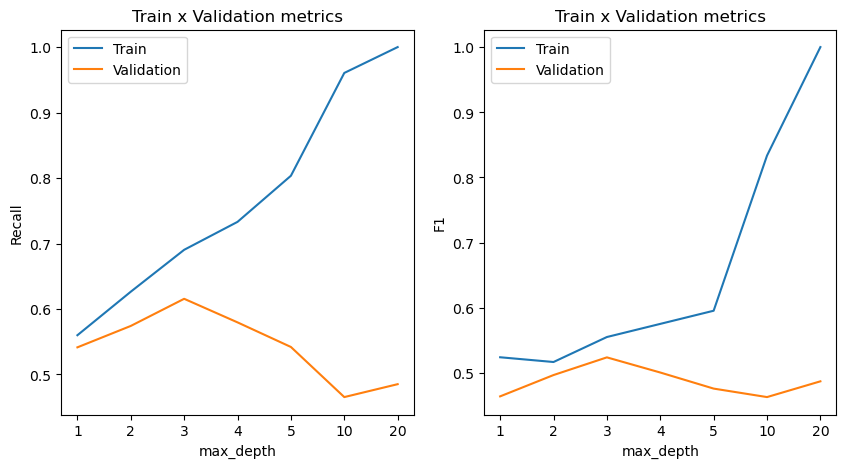

In [544]:
# Evaluating max_depth
recall_scores_train = []
recall_scores_cv = []
f1_scores_train =[]
f1_scores_cv = []

for max_depth in max_depth_list:
    dt = DecisionTreeClassifier(criterion=CRITERION,
                                max_depth=max_depth,
                                class_weight=CLASS_WEIGHT,
                                random_state=RANDOM_STATE
                                )
    
    dt.fit(X_train, y_train)
    pred_train = dt.predict(X_train)
    
    recall_train = recall_score(y_train, pred_train, average="macro")
    f1_train = f1_score(y_train, pred_train, average="macro")
    
    recall_scores_train.append(recall_train)
    f1_scores_train.append(f1_train)
    
    recall_cv = cross_val_score(dt, X_train, y_train, cv=cv, scoring="recall_macro")
    f1_cv = cross_val_score(dt, X_train, y_train, cv=cv, scoring="f1_macro")
    
    recall_cv_mean = recall_cv.mean()
    f1_cv_mean = f1_cv.mean()
    
    recall_scores_cv.append(recall_cv_mean)
    f1_scores_cv.append(f1_cv_mean)
    
    
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.title("Train x Validation metrics")
plt.xlabel("max_depth")
plt.ylabel("Recall")
plt.xticks(ticks=range(len(max_depth_list)), labels=max_depth_list)
plt.plot(recall_scores_train)
plt.plot(recall_scores_cv)
plt.legend(["Train", "Validation"])

plt.subplot(1,2,2)
plt.title("Train x Validation metrics")
plt.xlabel("max_depth")
plt.ylabel("F1")
plt.xticks(ticks=range(len(max_depth_list)), labels=max_depth_list)
plt.plot(f1_scores_train)
plt.plot(f1_scores_cv)
plt.legend(["Train", "Validation"])

plt.show()

Based on the above plots, both recall and F1 scores are increasing in training and validation when max_depth approaches 3, before the difference between training and validation increases significantly.

Hence, max_depth=3 is optimal to use for the optimised model.

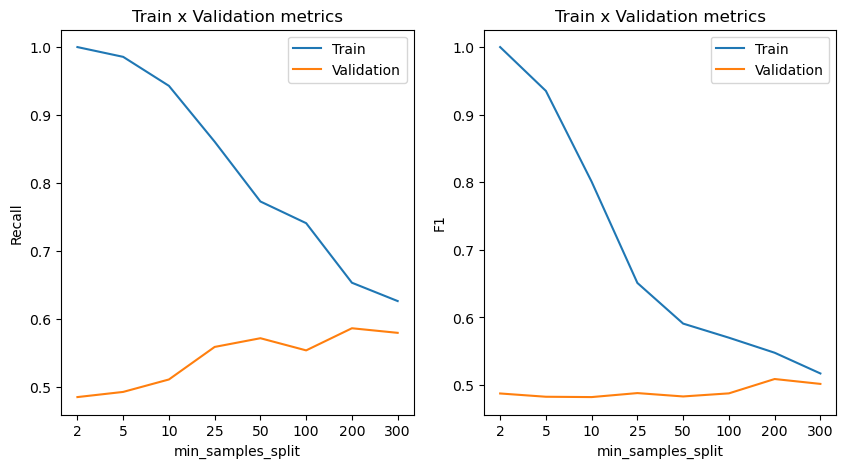

In [545]:
# Evaluating min_samples_split
recall_scores_train = []
recall_scores_cv = []
f1_scores_train =[]
f1_scores_cv = []

for min_samples_split in min_samples_split_list:
    dt = DecisionTreeClassifier(criterion=CRITERION,
                                min_samples_split=min_samples_split,
                                class_weight=CLASS_WEIGHT,
                                random_state=RANDOM_STATE
                                )
    
    dt.fit(X_train, y_train)
    pred_train = dt.predict(X_train)
    
    recall_train = recall_score(y_train, pred_train, average="macro")
    f1_train = f1_score(y_train, pred_train, average="macro")
    
    recall_scores_train.append(recall_train)
    f1_scores_train.append(f1_train)
    
    recall_cv = cross_val_score(dt, X_train, y_train, cv=cv, scoring="recall_macro")
    f1_cv = cross_val_score(dt, X_train, y_train, cv=cv, scoring="f1_macro")
    
    recall_cv_mean = recall_cv.mean()
    f1_cv_mean = f1_cv.mean()
    
    recall_scores_cv.append(recall_cv_mean)
    f1_scores_cv.append(f1_cv_mean)
    
    
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.title("Train x Validation metrics")
plt.xlabel("min_samples_split")
plt.ylabel("Recall")
plt.xticks(ticks=range(len(min_samples_split_list)), labels=min_samples_split_list)
plt.plot(recall_scores_train)
plt.plot(recall_scores_cv)
plt.legend(["Train", "Validation"])

plt.subplot(1,2,2)
plt.title("Train x Validation metrics")
plt.xlabel("min_samples_split")
plt.ylabel("F1")
plt.xticks(ticks=range(len(min_samples_split_list)), labels=min_samples_split_list)
plt.plot(f1_scores_train)
plt.plot(f1_scores_cv)
plt.legend(["Train", "Validation"])

plt.show()

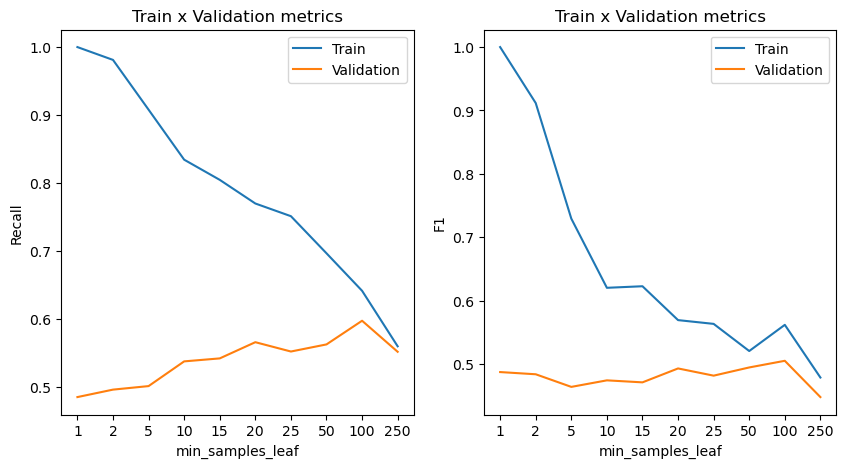

In [546]:
# Evaluating min_samples_leaf
recall_scores_train = []
recall_scores_cv = []
f1_scores_train =[]
f1_scores_cv = []

for min_samples_leaf in min_samples_leaf_list:
    dt = DecisionTreeClassifier(criterion=CRITERION,
                                min_samples_leaf=min_samples_leaf,
                                class_weight=CLASS_WEIGHT,
                                random_state=RANDOM_STATE
                                )
    
    dt.fit(X_train, y_train)
    pred_train = dt.predict(X_train)
    
    recall_train = recall_score(y_train, pred_train, average="macro")
    f1_train = f1_score(y_train, pred_train, average="macro")
    
    recall_scores_train.append(recall_train)
    f1_scores_train.append(f1_train)
    
    recall_cv = cross_val_score(dt, X_train, y_train, cv=cv, scoring="recall_macro")
    f1_cv = cross_val_score(dt, X_train, y_train, cv=cv, scoring="f1_macro")
    
    recall_cv_mean = recall_cv.mean()
    f1_cv_mean = f1_cv.mean()
    
    recall_scores_cv.append(recall_cv_mean)
    f1_scores_cv.append(f1_cv_mean)
    
    
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.title("Train x Validation metrics")
plt.xlabel("min_samples_leaf")
plt.ylabel("Recall")
plt.xticks(ticks=range(len(min_samples_leaf_list)), labels=min_samples_leaf_list)
plt.plot(recall_scores_train)
plt.plot(recall_scores_cv)
plt.legend(["Train", "Validation"])

plt.subplot(1,2,2)
plt.title("Train x Validation metrics")
plt.xlabel("min_samples_leaf")
plt.ylabel("F1")
plt.xticks(ticks=range(len(min_samples_leaf_list)), labels=min_samples_leaf_list)
plt.plot(f1_scores_train)
plt.plot(f1_scores_cv)
plt.legend(["Train", "Validation"])

plt.show()

Based on the plot of metrics against min_samples_split and min_samples_leaf above, it is hard to determine which are the best values of hyperparameters to use. GridSearchCV will be used to inform us which hyperparameter values are optimal, based on the cross validation score.

### Using GridSearchCV to choose the best hyperparameter values

GridSearchCV tries all possible hyperparameter combinations within a predefined space, which is usually better than trial and error (as done above) that is prone to missing optimal configurations, especially if hyperparameters are tested in silos.

In [547]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {"max_depth" : [1, 2, 3, 4, 5, 10, 20],
                "min_samples_split" : [2, 5, 10, 25, 50, 100, 200, 300, 500],
                "min_samples_leaf" : [1, 2, 5, 10, 15, 20, 25, 50, 100, 250, 500],
                "criterion" : ["gini", "entropy"],
                "class_weight" : ["balanced", None]
                }

# Initialise and run GridSearchCV
dt_baseline = DecisionTreeClassifier(random_state=RANDOM_STATE)
grid_search = GridSearchCV(estimator=dt_baseline,
                            param_grid=param_grid,
                            scoring="f1_macro",
                            cv=cv
                            )

# Build a grid search using the training set
grid_search.fit(X_train, y_train)

print(f"Best hyperparameter values: {grid_search.best_params_}")
print(f"Best mean cross-validated score: {grid_search.best_score_}")

Best hyperparameter values: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best mean cross-validated score: 0.5282419433691343


### Optimise the decision tree

The optimal decision tree will be built using the best hyperparameter values identified by GridSearchCV.

In [548]:
# Build the optimised decision tree model
dt_model = DecisionTreeClassifier(criterion="entropy",
                                    max_depth=20,
                                    min_samples_split=10,
                                    min_samples_leaf=1,
                                    class_weight=None,
                                    random_state=RANDOM_STATE
                                    )

# Build the decision tree model on the training set
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_split=10,
                       random_state=42)

In [549]:
# Compare recall and f1 scores in training and validation
pred_train = dt_model.predict(X_train)

recall_train = recall_score(y_train, pred_train, average="macro")
f1_train = f1_score(y_train, pred_train, average="macro")

recall_cv = cross_val_score(dt_model, X_train, y_train, cv=cv, scoring="recall_macro")
f1_cv = cross_val_score(dt_model, X_train, y_train, cv=cv, scoring="f1_macro")

recall_cv_mean = recall_cv.mean()
f1_cv_mean = f1_cv.mean()

print("Comparison of recall and f1 scores in the training and validation of the optimised decision tree model")
print(f"recall_train : {recall_train}")
print(f"f1_train : {f1_train}\n")
print(f"recall_cv_mean : {recall_cv_mean}")
print(f"f1_cv_mean : {f1_cv_mean}")

Comparison of recall and f1 scores in the training and validation of the optimised decision tree model
recall_train : 0.8147202470198773
f1_train : 0.8348890251538658

recall_cv_mean : 0.5274649884784114
f1_cv_mean : 0.5282419433691343


In [550]:
# Predict X_test
y_pred = dt_model.predict(X_test)
y_pred

array([1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 0, 0, 1, 2, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 0, 1, 0, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 0, 2, 0, 1, 1, 1, 2, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 2, 0, 0, 2, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1], dtype=int64)

### Visualise the decision tree

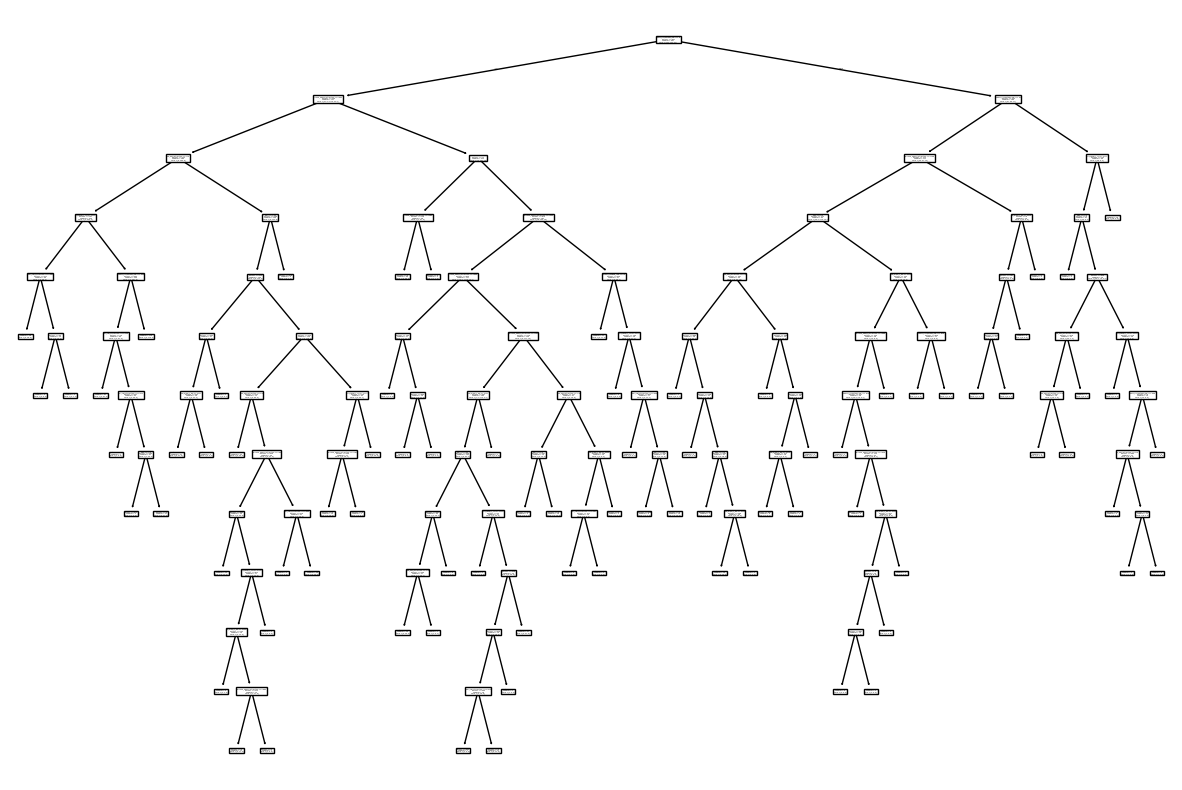

In [551]:
# Show the optimised decision tree model as a plot
from sklearn.tree import plot_tree

feature_cols = X.columns

plt.figure(figsize=(15,10))
plot_tree(dt_model.fit(X_train, y_train), feature_names=feature_cols)
plt.show()

In [552]:
# Show all class names
dt_model.classes_

array([0, 1, 2], dtype=int64)

### Confusion Matrix, Classfication Report and ROC-AUC

Evaluation of the optimised decision tree model will be done using a confusion matrix, classfication report and area under the ROC curve.

In [553]:
# Generate confusion matrix and display with each row and column labelled
from sklearn.metrics import confusion_matrix

cnf_matrix_test = confusion_matrix(y_test, y_pred, labels=dt_model.classes_)

cnf_matrix_test_df = pd.DataFrame(cnf_matrix_test, columns=["Diabetes_yes_pred", "Diabetes_no_pred", "Diabetes_borderline_pred"], 
                                    index=["Diabetes_yes_actual", "Diabetes_no_actual", "Diabetes_borderline_actual"])
cnf_matrix_test_df

,Diabetes_yes_pred,Diabetes_no_pred,Diabetes_borderline_pred
Diabetes_yes_actual,21,8,2
Diabetes_no_actual,17,161,8
Diabetes_borderline_actual,2,8,0


The optimised decision tree model did not manage to correctly classify any borderline diabetes cases.

In [554]:
# Generate classification report
from sklearn.metrics import classification_report

dt_model_classfication_report = classification_report(y_test, y_pred, target_names=["Diabetes_yes", "Diabetes_no", "Diabetes_borderline"])

# Show classification report
print("Classification report of optimised decision tree")
print(dt_model_classfication_report)

Classification report of optimised decision tree
                     precision    recall  f1-score   support

       Diabetes_yes       0.53      0.68      0.59        31
        Diabetes_no       0.91      0.87      0.89       186
Diabetes_borderline       0.00      0.00      0.00        10

           accuracy                           0.80       227
          macro avg       0.48      0.51      0.49       227
       weighted avg       0.82      0.80      0.81       227



In [555]:
from sklearn.metrics import roc_auc_score

y_pred_proba = dt_model.predict_proba(X_test)

dt_model_roc_auc = roc_auc_score(y_test, y_pred_proba, average="macro", multi_class="ovr")
print(dt_model_roc_auc)

0.6817870211289341


### Feature Importance

In detecting Type 2 diabetes, it is important to identify which features contribute to the optimised model's prediction.
This will also be used in comparison to other classification techniques explored later.

Feature importance values (entropy) sorted in descending order
hba1c_percentage_log: 0.41161474613784155
bmi: 0.13787763367365335
glucose_hba1c_interaction: 0.12213892327200815
age: 0.06608414667318464
bp_age_interaction: 0.06564739399110647
hdl_mmol_L_log: 0.06279505240243848
bmi_age_interaction: 0.05147732829794715
fpg_mmol_L_log: 0.05059507799660702
gender: 0.02274531118751552
current_smoking_freq: 0.009024386367697798
high_blood_pressure: 0.0


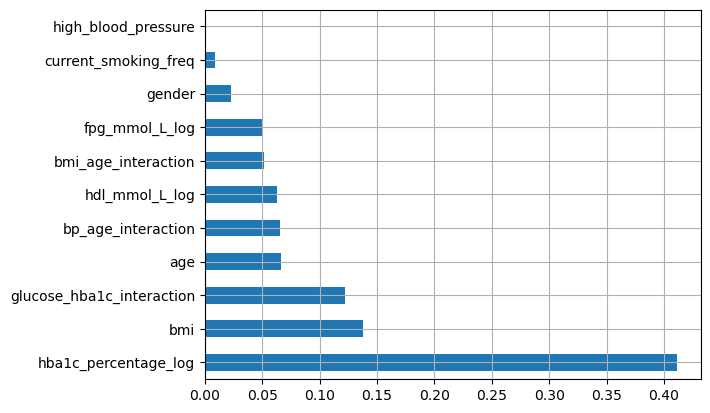

In [602]:
# Show the entropy importance of each feature
feature_importance = pd.Series(dt_model.feature_importances_, index=feature_cols)

feature_importance_sorted = feature_importance.sort_values(ascending=False)

print("Feature importance values (entropy) sorted in descending order")

for col, feature_val in feature_importance_sorted.items():
    print(f"{col}: {feature_val}")

feature_importance_sorted.plot(kind="barh")
plt.grid()

### Further exploration into the optimised decision tree model results

While the best hyperparameter values resulted from GridSearchCV were used, further analysis using the code below shown that the combination of GridSearchCV hyperparameter values above did not optimise the metric scores on the test set. This is especially the case in predicting for 'Diabetes_borderline', where all cases are wrongly classified.

It may be possible that these "best" hyperparameters worked well on the cross validation splits, but did not perform as well on unseen data in X_test.

For the purpose of exploration, further trial and error using the code below with support from the plots earlier. Another set of hyperparameters values were found to improve the results of 'Diabetes_borderline':
- criterion="entropy"
- max_depth=3
- min_samples_split=50
- min_samples_leaf=10
- class_weight="balanced"

Note:
- min_samples_split=50 resulted in the same results as min_samples_split=2
- min_samples_leaf=10 resulted in the same results as min_samples_split=5

Hence, min_samples_split=50 and min_samples_leaf=10 is chosen to keep the optimised model simple and less likely to overfit.

This gave a better result for 'Diabetes_borderline' on the test set, but also resulted in a lower cross validation score and worse metric score for 'Diabetes_no'.

In [557]:
# Build the optimised decision tree model
dt_model_explore = DecisionTreeClassifier(criterion="entropy",
                                    max_depth=3,
                                    min_samples_split=50,
                                    min_samples_leaf=10,
                                    class_weight="balanced",
                                    random_state=RANDOM_STATE
                                    )

# Build the decision tree model on the training set
dt_model_explore.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=3, min_samples_leaf=10, min_samples_split=50,
                       random_state=42)

In [558]:
# Compare recall and f1 scores in training and validation
pred_train = dt_model_explore.predict(X_train)

recall_train = recall_score(y_train, pred_train, average="macro")
f1_train = f1_score(y_train, pred_train, average="macro")

recall_cv = cross_val_score(dt_model_explore, X_train, y_train, cv=cv, scoring="recall_macro")
f1_cv = cross_val_score(dt_model_explore, X_train, y_train, cv=cv, scoring="f1_macro")

recall_cv_mean = recall_cv.mean()
f1_cv_mean = f1_cv.mean()

print("Comparison of recall and f1 scores in the training and validation of the optimised decision tree model")
print(f"recall_train : {recall_train}")
print(f"f1_train : {f1_train}\n")
print(f"recall_cv_mean : {recall_cv_mean}")
print(f"f1_cv_mean : {f1_cv_mean}")

Comparison of recall and f1 scores in the training and validation of the optimised decision tree model
recall_train : 0.689052489603237
f1_train : 0.5516783262176408

recall_cv_mean : 0.612837609421502
f1_cv_mean : 0.5202870317521672


In [559]:
# Predict X_test
y_pred = dt_model_explore.predict(X_test)
y_pred

array([1, 2, 2, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 2, 0, 1, 2, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 1, 2, 1, 1, 1, 2,
       2, 1, 1, 2, 1, 0, 1, 0, 1, 1, 2, 2, 1, 0, 1, 1, 1, 1, 2, 0, 1, 1,
       1, 1, 1, 2, 0, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 0, 1, 1, 1,
       2, 1, 2, 1, 2, 1, 1, 2, 0, 1, 2, 1, 1, 0, 2, 1, 2, 2, 0, 2, 1, 2,
       1, 1, 1, 1, 0, 0, 2, 1, 1, 2, 2, 2, 1, 2, 0, 0, 2, 2, 0, 1, 1, 0,
       2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 2, 1, 2, 2, 1, 2, 1, 0, 1, 2, 2, 1, 1, 1, 0, 1, 0, 0, 2, 1,
       2, 1, 2, 0, 1, 2, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 0, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 0, 0, 0, 0, 2, 1, 1, 0, 1,
       1, 2, 1, 1, 0, 1, 1], dtype=int64)

### Visualise the decision tree

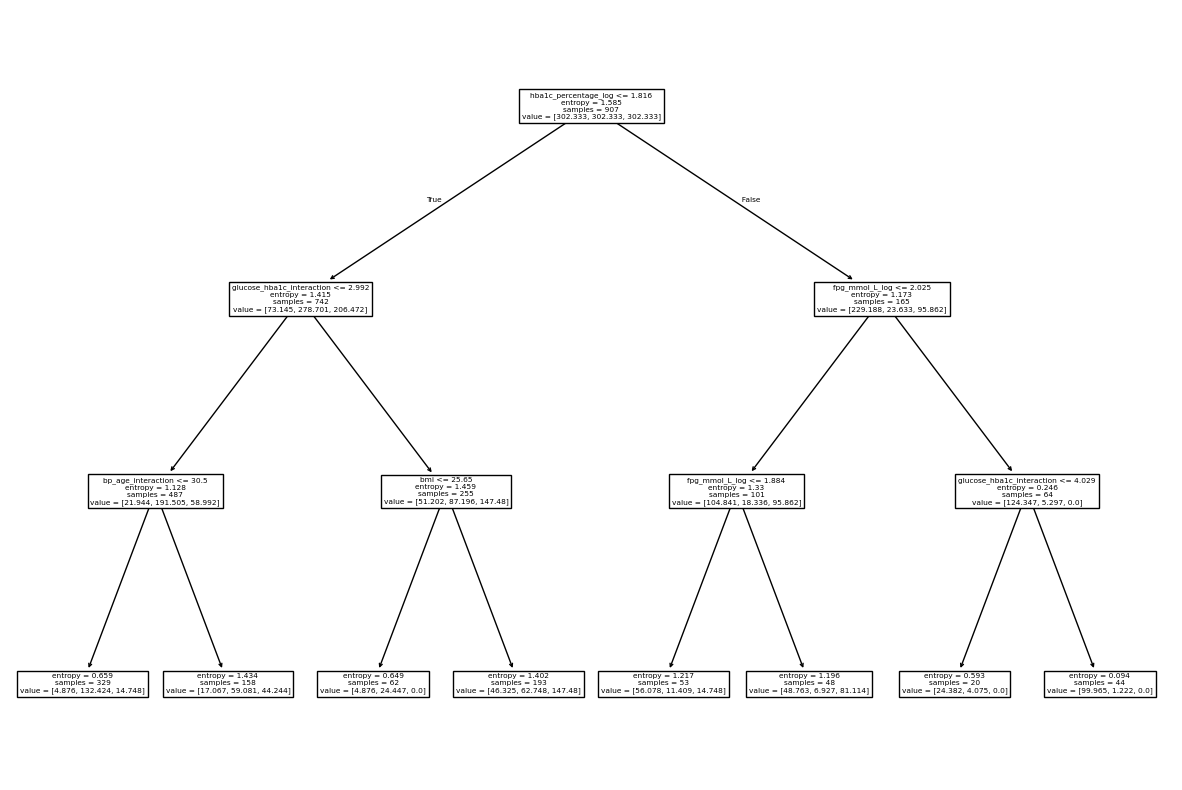

In [560]:
# Show the optimised decision tree model as a plot
from sklearn.tree import plot_tree

feature_cols = X.columns

plt.figure(figsize=(15,10))
plot_tree(dt_model_explore.fit(X_train, y_train), feature_names=feature_cols)
plt.show()

In [561]:
# Show all class names
dt_model_explore.classes_

array([0, 1, 2], dtype=int64)

### Confusion Matrix, Classfication Report and ROC-AUC

Evaluation of the explored decision tree model will be done using a confusion matrix, classfication report and area under the ROC curve.

In [562]:
# Generate confusion matrix and display with each row and column labelled
from sklearn.metrics import confusion_matrix

cnf_matrix_test = confusion_matrix(y_test, y_pred, labels=dt_model.classes_)

cnf_matrix_test_df = pd.DataFrame(cnf_matrix_test, columns=["Diabetes_yes_pred", "Diabetes_no_pred", "Diabetes_borderline_pred"], 
                                    index=["Diabetes_yes_actual", "Diabetes_no_actual", "Diabetes_borderline_actual"])
cnf_matrix_test_df

,Diabetes_yes_pred,Diabetes_no_pred,Diabetes_borderline_pred
Diabetes_yes_actual,20,4,7
Diabetes_no_actual,12,128,46
Diabetes_borderline_actual,3,2,5


This sub-optimal decision tree managed to correctly classify half of the borderline diabetes cases, but with a lower cross validation score.

In [563]:
# Generate classification report
from sklearn.metrics import classification_report

dt_model_explore_classfication_report = classification_report(y_test, y_pred, target_names=["Diabetes_yes", "Diabetes_no", "Diabetes_borderline"])

# Show classification report
print("Classification report of optimised decision tree")
print(dt_model_explore_classfication_report)

Classification report of optimised decision tree
                     precision    recall  f1-score   support

       Diabetes_yes       0.57      0.65      0.61        31
        Diabetes_no       0.96      0.69      0.80       186
Diabetes_borderline       0.09      0.50      0.15        10

           accuracy                           0.67       227
          macro avg       0.54      0.61      0.52       227
       weighted avg       0.86      0.67      0.74       227



In [564]:
from sklearn.metrics import roc_auc_score

y_pred_proba = dt_model.predict_proba(X_test)

dt_model_explore_roc_auc = roc_auc_score(y_test, y_pred_proba, average="macro", multi_class="ovr")
print(dt_model_explore_roc_auc)

0.6817870211289341


### Feature Importance

Feature importance values (entropy) sorted in descending order
hba1c_percentage_log: 0.4805268609890805
fpg_mmol_L_log: 0.2290123246065163
glucose_hba1c_interaction: 0.14334010978799488
bmi: 0.07768351475793082
bp_age_interaction: 0.06943718985847741
high_blood_pressure: 0.0
gender: 0.0
age: 0.0
current_smoking_freq: 0.0
hdl_mmol_L_log: 0.0
bmi_age_interaction: 0.0


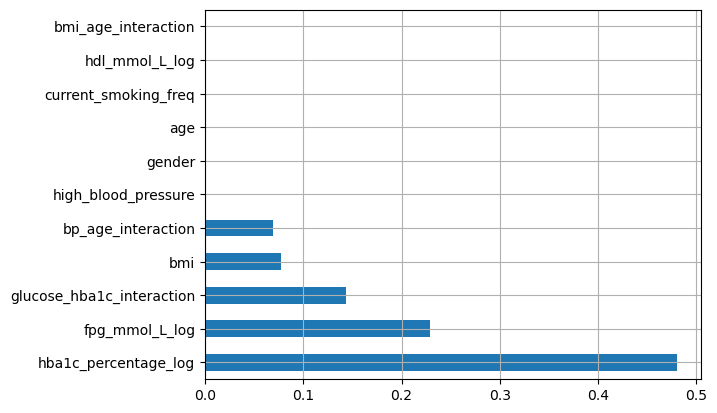

In [601]:
# Show the entropy importance of each feature
feature_importance = pd.Series(dt_model_explore.feature_importances_, index=feature_cols)

feature_importance_sorted = feature_importance.sort_values(ascending=False)

print("Feature importance values (entropy) sorted in descending order")

for col, feature_val in feature_importance_sorted.items():
    print(f"{col}: {feature_val}")

feature_importance_sorted.plot(kind="barh")
plt.grid()

## Random Forest

Similar to building an optimised decision tree, different values of hyperparameters will be tested.

An additional hyperparameter is n_estimators, which specifies the number of decision trees that make up the random forest.

In [566]:
from sklearn.ensemble import RandomForestClassifier

In [567]:
# Create a list of values for the Random Forest Classifier parameters to observe their effects on model performance
max_depth_list = [1, 2, 3, 4, 5, 10, 20]
min_samples_split_list = [2, 5, 10, 25, 50, 100, 200, 300]
min_samples_leaf_list = [1, 2, 5, 10, 15, 20, 25, 50, 100, 250]
n_estimators_list = [2, 5, 10, 15, 20, 25, 50, 100]

CRITERION = "entropy"
CLASS_WEIGHT = "balanced"
RANDOM_STATE = 42

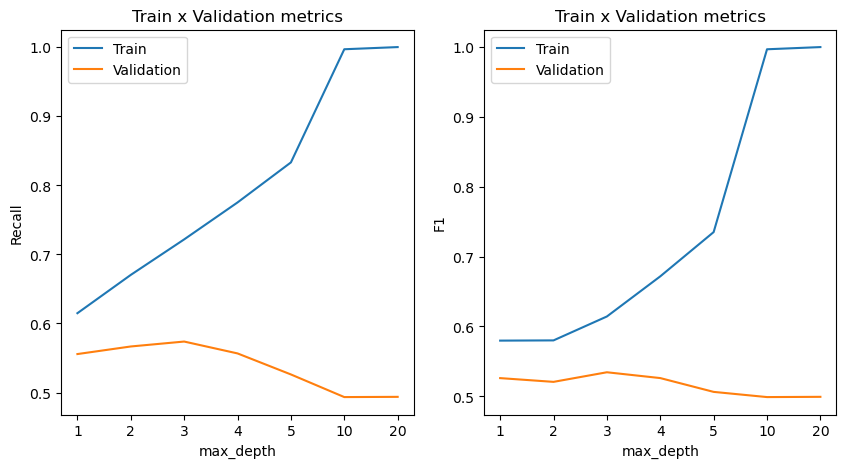

In [568]:
# Evaluating max_depth
recall_scores_train = []
recall_scores_cv = []
f1_scores_train =[]
f1_scores_cv = []

for max_depth in max_depth_list:
    rf = RandomForestClassifier(criterion=CRITERION,
                                max_depth=max_depth,
                                class_weight=CLASS_WEIGHT,
                                random_state=RANDOM_STATE
                                )
    
    rf.fit(X_train, y_train)
    pred_train = rf.predict(X_train)
    
    recall_train = recall_score(y_train, pred_train, average="macro")
    f1_train = f1_score(y_train, pred_train, average="macro")
    
    recall_scores_train.append(recall_train)
    f1_scores_train.append(f1_train)
    
    recall_cv = cross_val_score(rf, X_train, y_train, cv=cv, scoring="recall_macro")
    f1_cv = cross_val_score(rf, X_train, y_train, cv=cv, scoring="f1_macro")
    
    recall_cv_mean = recall_cv.mean()
    f1_cv_mean = f1_cv.mean()
    
    recall_scores_cv.append(recall_cv_mean)
    f1_scores_cv.append(f1_cv_mean)
    
    
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.title("Train x Validation metrics")
plt.xlabel("max_depth")
plt.ylabel("Recall")
plt.xticks(ticks=range(len(max_depth_list)), labels=max_depth_list)
plt.plot(recall_scores_train)
plt.plot(recall_scores_cv)
plt.legend(["Train", "Validation"])

plt.subplot(1,2,2)
plt.title("Train x Validation metrics")
plt.xlabel("max_depth")
plt.ylabel("F1")
plt.xticks(ticks=range(len(max_depth_list)), labels=max_depth_list)
plt.plot(f1_scores_train)
plt.plot(f1_scores_cv)
plt.legend(["Train", "Validation"])

plt.show()

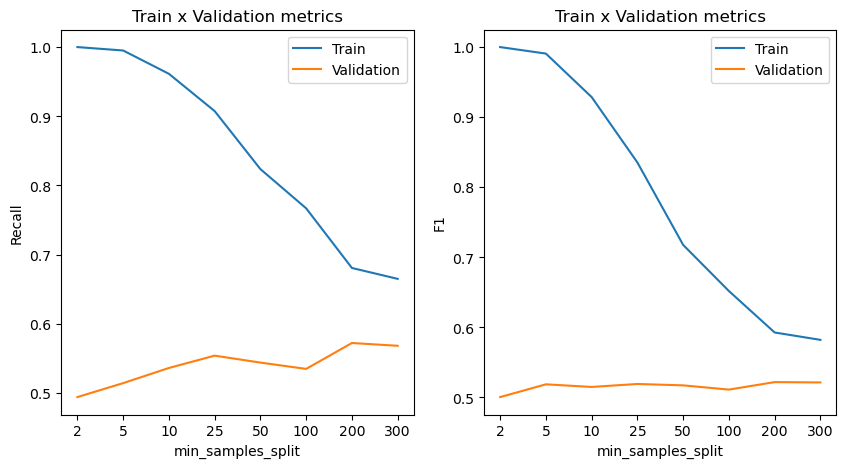

In [569]:
# Evaluating min_samples_split
recall_scores_train = []
recall_scores_cv = []
f1_scores_train =[]
f1_scores_cv = []

for min_samples_split in min_samples_split_list:
    rf = RandomForestClassifier(criterion=CRITERION,
                                min_samples_split=min_samples_split,
                                class_weight=CLASS_WEIGHT,
                                random_state=RANDOM_STATE
                                )
    
    rf.fit(X_train, y_train)
    pred_train = rf.predict(X_train)
    
    recall_train = recall_score(y_train, pred_train, average="macro")
    f1_train = f1_score(y_train, pred_train, average="macro")
    
    recall_scores_train.append(recall_train)
    f1_scores_train.append(f1_train)
    
    recall_cv = cross_val_score(rf, X_train, y_train, cv=cv, scoring="recall_macro")
    f1_cv = cross_val_score(rf, X_train, y_train, cv=cv, scoring="f1_macro")
    
    recall_cv_mean = recall_cv.mean()
    f1_cv_mean = f1_cv.mean()
    
    recall_scores_cv.append(recall_cv_mean)
    f1_scores_cv.append(f1_cv_mean)
    
    
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.title("Train x Validation metrics")
plt.xlabel("min_samples_split")
plt.ylabel("Recall")
plt.xticks(ticks=range(len(min_samples_split_list)), labels=min_samples_split_list)
plt.plot(recall_scores_train)
plt.plot(recall_scores_cv)
plt.legend(["Train", "Validation"])

plt.subplot(1,2,2)
plt.title("Train x Validation metrics")
plt.xlabel("min_samples_split")
plt.ylabel("F1")
plt.xticks(ticks=range(len(min_samples_split_list)), labels=min_samples_split_list)
plt.plot(f1_scores_train)
plt.plot(f1_scores_cv)
plt.legend(["Train", "Validation"])

plt.show()

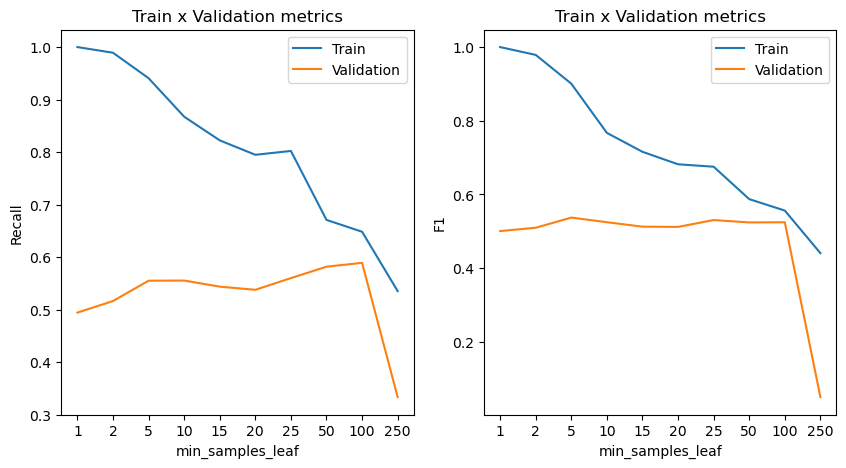

In [570]:
# Evaluating min_samples_leaf
recall_scores_train = []
recall_scores_cv = []
f1_scores_train =[]
f1_scores_cv = []

for min_samples_leaf in min_samples_leaf_list:
    rf = RandomForestClassifier(criterion=CRITERION,
                                min_samples_leaf=min_samples_leaf,
                                class_weight=CLASS_WEIGHT,
                                random_state=RANDOM_STATE
                                )
    
    rf.fit(X_train, y_train)
    pred_train = rf.predict(X_train)
    
    recall_train = recall_score(y_train, pred_train, average="macro")
    f1_train = f1_score(y_train, pred_train, average="macro")
    
    recall_scores_train.append(recall_train)
    f1_scores_train.append(f1_train)
    
    recall_cv = cross_val_score(rf, X_train, y_train, cv=cv, scoring="recall_macro")
    f1_cv = cross_val_score(rf, X_train, y_train, cv=cv, scoring="f1_macro")
    
    recall_cv_mean = recall_cv.mean()
    f1_cv_mean = f1_cv.mean()
    
    recall_scores_cv.append(recall_cv_mean)
    f1_scores_cv.append(f1_cv_mean)
    
    
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.title("Train x Validation metrics")
plt.xlabel("min_samples_leaf")
plt.ylabel("Recall")
plt.xticks(ticks=range(len(min_samples_leaf_list)), labels=min_samples_leaf_list)
plt.plot(recall_scores_train)
plt.plot(recall_scores_cv)
plt.legend(["Train", "Validation"])

plt.subplot(1,2,2)
plt.title("Train x Validation metrics")
plt.xlabel("min_samples_leaf")
plt.ylabel("F1")
plt.xticks(ticks=range(len(min_samples_leaf_list)), labels=min_samples_leaf_list)
plt.plot(f1_scores_train)
plt.plot(f1_scores_cv)
plt.legend(["Train", "Validation"])

plt.show()

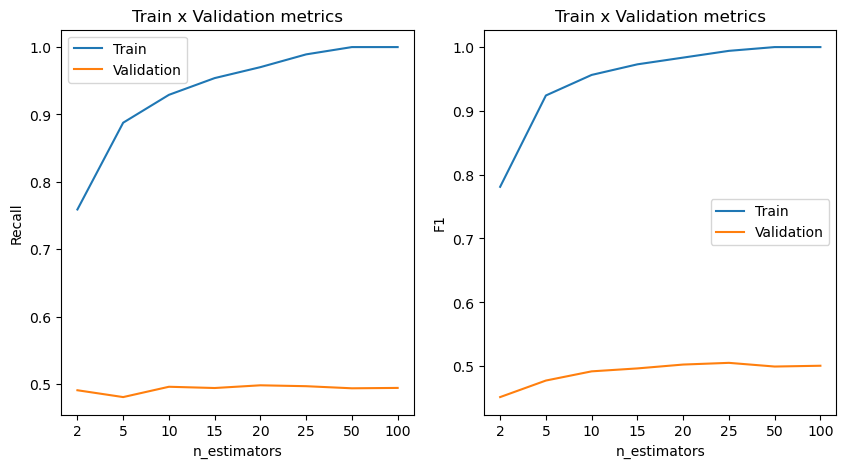

In [571]:
# Evaluating n_estimators
recall_scores_train = []
recall_scores_cv = []
f1_scores_train =[]
f1_scores_cv = []

for n_estimators in n_estimators_list:
    rf = RandomForestClassifier(criterion=CRITERION,
                                n_estimators=n_estimators,
                                class_weight=CLASS_WEIGHT,
                                random_state=RANDOM_STATE
                                )
    
    rf.fit(X_train, y_train)
    pred_train = rf.predict(X_train)
    
    recall_train = recall_score(y_train, pred_train, average="macro")
    f1_train = f1_score(y_train, pred_train, average="macro")
    
    recall_scores_train.append(recall_train)
    f1_scores_train.append(f1_train)
    
    recall_cv = cross_val_score(rf, X_train, y_train, cv=cv, scoring="recall_macro")
    f1_cv = cross_val_score(rf, X_train, y_train, cv=cv, scoring="f1_macro")
    
    recall_cv_mean = recall_cv.mean()
    f1_cv_mean = f1_cv.mean()
    
    recall_scores_cv.append(recall_cv_mean)
    f1_scores_cv.append(f1_cv_mean)
    
    
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.title("Train x Validation metrics")
plt.xlabel("n_estimators")
plt.ylabel("Recall")
plt.xticks(ticks=range(len(n_estimators_list)), labels=n_estimators_list)
plt.plot(recall_scores_train)
plt.plot(recall_scores_cv)
plt.legend(["Train", "Validation"])

plt.subplot(1,2,2)
plt.title("Train x Validation metrics")
plt.xlabel("n_estimators")
plt.ylabel("F1")
plt.xticks(ticks=range(len(n_estimators_list)), labels=n_estimators_list)
plt.plot(f1_scores_train)
plt.plot(f1_scores_cv)
plt.legend(["Train", "Validation"])

plt.show()

In [572]:
# Define parameter grid
param_grid = {"max_depth" : [1, 2, 3, 4, 5, 10, 20],
                "min_samples_split" : [2, 5, 10, 25, 50, 100, 200, 300],
                "min_samples_leaf" : [1, 2, 5, 10, 15, 20, 25, 50, 100, 250],
                "n_estimators" : [2, 5, 10, 15, 20, 25, 50, 100],
                "criterion" : ["gini", "entropy"],
                "class_weight" : ["balanced", None]
}

# Initialise and run GridSearchCV
rf_baseline = RandomForestClassifier(random_state=RANDOM_STATE)
grid_search = GridSearchCV(estimator=rf_baseline,
                            param_grid=param_grid,
                            scoring="f1_macro",
                            cv=cv,
                            n_jobs=-1
                            )

# Build the grid search on the training set
grid_search.fit(X_train, y_train)

print(f"Best hyperparameters values: {grid_search.best_params_}")
print(f"Best mean cross-validated score: {grid_search.best_score_}")

Best hyperparameters values: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 15}
Best mean cross-validated score: 0.5589441090169571


### Optimise the Random Forest model

The best hyperparameter values found using GridSearchCV are used to build the optimised random forest model:
- criterion="gini"
- max_depth=5
- min_samples_split=2
- min_samples_leaf=10
- n_estimators=15
- class_weight="balanced"

In [587]:
# Build the optimised random forest model
rf_model = RandomForestClassifier(criterion="gini",
                                    max_depth=3,
                                    min_samples_split=2,
                                    min_samples_leaf=10,
                                    n_estimators=15,
                                    class_weight=CLASS_WEIGHT,
                                    random_state=RANDOM_STATE
                                    )

# Build the random forest model on the training set
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=3,
                       min_samples_leaf=10, n_estimators=15, random_state=42)

In [588]:
# Compare recall and f1 scores in training and validation
pred_train = rf_model.predict(X_train)

recall_train = recall_score(y_train, pred_train, average="macro")
f1_train = f1_score(y_train, pred_train, average="macro")

recall_cv = cross_val_score(rf_model, X_train, y_train, cv=cv, scoring="recall_macro")
f1_cv = cross_val_score(rf_model, X_train, y_train, cv=cv, scoring="f1_macro")

recall_cv_mean = recall_cv.mean()
f1_cv_mean = f1_cv.mean()

print("Comparison of recall and f1 scores in the training and validation of the optimised random forest model")
print(f"recall_train : {recall_train}")
print(f"f1_train : {f1_train}\n")
print(f"recall_cv_mean : {recall_cv_mean}")
print(f"f1_cv_mean : {f1_cv_mean}")

Comparison of recall and f1 scores in the training and validation of the optimised random forest model
recall_train : 0.6991806297508241
f1_train : 0.5996619308867728

recall_cv_mean : 0.5679269941082021
f1_cv_mean : 0.5296361345496994


In [589]:
# Predict X_test
y_pred = rf_model.predict(X_test)
y_pred

array([2, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2,
       1, 1, 1, 2, 1, 0, 1, 0, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 0, 2, 1,
       1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 0, 2, 1, 1, 2,
       1, 1, 1, 1, 0, 2, 2, 1, 1, 2, 2, 1, 1, 1, 0, 0, 2, 2, 0, 1, 1, 0,
       2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 2, 2, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 0, 2, 0, 0, 0, 2, 1, 1, 2, 1,
       1, 2, 1, 1, 2, 1, 1], dtype=int64)

### Confusion Matrix, Classfication Report and ROC-AUC

Evaluation of the optimised decision tree model will be done using a confusion matrix, classfication report and area under the ROC curve.

In [590]:
# Import library to show confusion matrix
from sklearn.metrics import confusion_matrix

# Generate confusion matrix and display with each row and column labelled
cnf_matrix_test = confusion_matrix(y_test, y_pred, labels=rf_model.classes_)

cnf_matrix_test_df = pd.DataFrame(cnf_matrix_test, columns=["Diabetes_yes_pred", "Diabetes_no_pred", "Diabetes_borderline_pred"], 
                                    index=["Diabetes_yes_actual", "Diabetes_no_actual", "Diabetes_borderline_actual"])

cnf_matrix_test_df

,Diabetes_yes_pred,Diabetes_no_pred,Diabetes_borderline_pred
Diabetes_yes_actual,20,3,8
Diabetes_no_actual,9,143,34
Diabetes_borderline_actual,2,3,5


In [591]:
# Import library to generate classification report
from sklearn.metrics import classification_report

rf_model_classfication_report = classification_report(y_test, y_pred, target_names=["Diabetes_yes", "Diabetes_no", "Diabetes_borderline"])

# Show classification report
print("Classification report of optimised random forest")
print(rf_model_classfication_report)

Classification report of optimised random forest
                     precision    recall  f1-score   support

       Diabetes_yes       0.65      0.65      0.65        31
        Diabetes_no       0.96      0.77      0.85       186
Diabetes_borderline       0.11      0.50      0.18        10

           accuracy                           0.74       227
          macro avg       0.57      0.64      0.56       227
       weighted avg       0.88      0.74      0.80       227



In [592]:
from sklearn.metrics import roc_auc_score

y_pred_proba = rf_model.predict_proba(X_test)

rf_model_roc_auc = roc_auc_score(y_test, y_pred_proba, average="macro", multi_class="ovr")
print(rf_model_roc_auc)

0.8153240525163645


### Feature Importance

Feature importance values (gini) sorted in descending order
fpg_mmol_L_log: 0.35229095404829663
glucose_hba1c_interaction: 0.24692339673095426
hba1c_percentage_log: 0.2323634449636822
bmi_age_interaction: 0.08221879795983901
hdl_mmol_L_log: 0.027318306751881516
age: 0.01886169210588461
bmi: 0.012282686781534718
high_blood_pressure: 0.011291418691245511
gender: 0.010513786123311435
bp_age_interaction: 0.005935515843370263
current_smoking_freq: 0.0


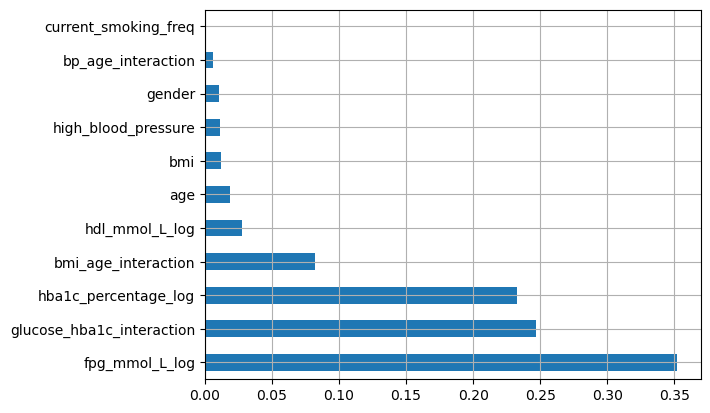

In [600]:
# Show the entropy importance of each feature
feature_importance = pd.Series(rf_model.feature_importances_, index=feature_cols)

feature_importance_sorted = feature_importance.sort_values(ascending=False)

print("Feature importance values (gini) sorted in descending order")

for col, feature_val in feature_importance_sorted.items():
    print(f"{col}: {feature_val}")

feature_importance_sorted.plot(kind="barh")
plt.grid()

## XGBoost

On top of the hyperparameters seen in the Random Forest Classifier, XGBoost has an additional hyperparameters learning_rate, which specifies the size of the step on gradient descent and prevent overfitting.

In [580]:
# Import library
from xgboost import XGBClassifier

In [581]:
# Define the parameter grid
param_grid = {"n_estimators" : [150, 200],
                "max_depth" : [3, 5],
                "class_weight" : ["balanced"],
                "learning_rate" : [0.01, 0.1],
                "reg_lambda" : [1, 5.0],
                "reg_alpha" : [0],
                "gamma" : [0.2, 0.3],
                "subsample": [0.8, 1.0],
                "colsample_bytree": [0.8, 1.0],
                "min_child_weight": [1,3]
}

# Initialise and run GridSearchCV
xgb_baseline = XGBClassifier(objective="multi:softmax",
                                num_class=3,
                                random_state=RANDOM_STATE)
grid_search = GridSearchCV(estimator=xgb_baseline,
                            param_grid=param_grid,
                            scoring="f1_macro",
                            cv=cv,
                            n_jobs=-1,
                            verbose=1
                            )

# Build the grid search using the training set
grid_search.fit(X_train, y_train)

print(f"Best hyperparameters values: {grid_search.best_params_}")
print(f"Best mean cross-validated score: {grid_search.best_score_}")

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
Best hyperparameters values: {'class_weight': 'balanced', 'colsample_bytree': 1.0, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}
Best mean cross-validated score: 0.5316741254369187


### Optimise the XGBoost model

The best hyperparameter values from GridSearchCV are used to build the optimised XGBoost model.

In [594]:
xgb_model = XGBClassifier(objective="softmax",
                            num_class=3,
                            n_estimators=200,
                            max_depth=3,
                            class_weight=CLASS_WEIGHT,
                            learning_rate=0.1,
                            reg_lambda=1,
                            reg_alpha=0,
                            gamma=0.3,
                            subsample=0.8,
                            colsample_bytree=1.0,
                            min_child_weight=1,
                            random_state=RANDOM_STATE
                            )

# Fit the optimised XGBClassifier to the training set
xgb_model.fit(X_train, y_train)

# Make prediction on the test set
y_pred = xgb_model.predict(X_test)
y_pred

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1], dtype=int64)

### Confusion Matrix, Classfication Report and ROC-AUC

Evaluation of the optimised decision tree model will be done using a confusion matrix, classfication report and area under the ROC curve.

In [595]:
# Import library to show confusion matrix
from sklearn.metrics import confusion_matrix

# Generate confusion matrix and display with each row and column labelled
cnf_matrix_test = confusion_matrix(y_test, y_pred, labels=xgb_model.classes_)

cnf_matrix_test_df = pd.DataFrame(cnf_matrix_test, columns=["Diabetes_yes_pred", "Diabetes_no_pred", "Diabetes_borderline_pred"], 
                                    index=["Diabetes_yes_actual", "Diabetes_no_actual", "Diabetes_borderline_actual"])

cnf_matrix_test_df

,Diabetes_yes_pred,Diabetes_no_pred,Diabetes_borderline_pred
Diabetes_yes_actual,17,14,0
Diabetes_no_actual,10,173,3
Diabetes_borderline_actual,4,6,0


In [596]:
# Import library to generate classification report
from sklearn.metrics import classification_report

xgb_model_classfication_report = classification_report(y_test, y_pred, target_names=["Diabetes_yes", "Diabetes_no", "Diabetes_borderline"])

# Show classification report
print("Classification report of optimised XGBoost")
print(xgb_model_classfication_report)

Classification report of optimised XGBoost
                     precision    recall  f1-score   support

       Diabetes_yes       0.55      0.55      0.55        31
        Diabetes_no       0.90      0.93      0.91       186
Diabetes_borderline       0.00      0.00      0.00        10

           accuracy                           0.84       227
          macro avg       0.48      0.49      0.49       227
       weighted avg       0.81      0.84      0.82       227



In [597]:
from sklearn.metrics import roc_auc_score

y_pred_proba = xgb_model.predict_proba(X_test)

xgb_model_roc_auc = roc_auc_score(y_test, y_pred_proba, average="macro", multi_class="ovr")
print(xgb_model_roc_auc)

0.8016593786741026


### Feature Importance

Feature importance values (gain) sorted in descending order
hba1c_percentage_log: 0.29123616218566895
gender: 0.08567774295806885
glucose_hba1c_interaction: 0.08314016461372375
fpg_mmol_L_log: 0.0743793174624443
high_blood_pressure: 0.07187290489673615
age: 0.07163582742214203
bp_age_interaction: 0.06813306361436844
bmi_age_interaction: 0.06544017046689987
bmi: 0.06513553112745285
hdl_mmol_L_log: 0.0639689639210701
current_smoking_freq: 0.059380125254392624


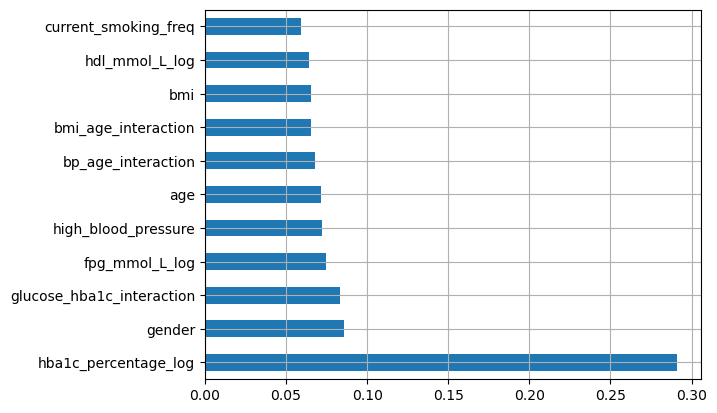

In [599]:
# Show the entropy importance of each feature
feature_importance = pd.Series(xgb_model.feature_importances_, index=feature_cols)

feature_importance_sorted = feature_importance.sort_values(ascending=False)

print("Feature importance values (gain) sorted in descending order")

for col, feature_val in feature_importance_sorted.items():
    print(f"{col}: {feature_val}")

feature_importance_sorted.plot(kind="barh")
plt.grid()